<a href="https://colab.research.google.com/github/tavishcode/fyp/blob/master/notebooks/caching_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Activation, GRU, Dense
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import scale, StandardScaler, RobustScaler, MinMaxScaler
from collections import OrderedDict, defaultdict, Counter
import heapq
from google.colab import drive
drive.mount('/content/drive')
plt.rcParams['figure.figsize'] = [10, 8]

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
test_probs = pd.read_csv('drive/My Drive/large_test_probs.csv')

In [0]:
content_names = test_probs['name'].values

In [0]:
probs = test_probs.iloc[:,1:].values

In [0]:
reqs_per_day = 500000

In [0]:
# constants
num_contents = len(content_names)
sim_length = 7 * 10 # if sim length is not a multiple of 7, the debug pred time series will break!
seed = 123

In [0]:
test_set = probs[:, :sim_length]

In [0]:
test_set.shape

(145063, 70)

In [0]:
class ContentStore:
    def __init__(self, size):
        self.size = size
        self.hits = 0
        self.misses = 0

    def add(self, item):
        pass

    def get_helper(self, item):
        # function is overriden for custom get implementations
        # in derived classes
        pass

    def get(self, item):
        item = self.get_helper(item)
        if item != None:
            self.hits += 1
        else:
            self.misses += 1
        return item

## Traditional Caching Algorithms

### LRU

In [0]:
class LruContentStore(ContentStore):
    def __init__(self, size):
        super().__init__(size)
        self.store = OrderedDict()
        self.start_counting = False

    def add(self, item):
        # returns can cache ?, victim
        victim = None
        if item in self.store or self.size <= 0:
            return False, victim
        if self.size:
            if(len(self.store) == self.size):
                # remove top element (least recent element)
                victim, _ = self.store.popitem(last=False)
            self.store[item] = item
            return True, victim

    def get_helper(self, item):
        try:
            cached_item = self.store.pop(item)
            # re-insert content to maintain lru-order
            self.store[item] = cached_item
            return cached_item
        except:
            return None

### Random

In [0]:
class RandomContentStore(ContentStore):
    def __init__(self, size):
        super().__init__(size)
        self.rng = np.random.RandomState(123)
        self.size = size
        self.store = {}

    def add(self, item):
        if self.size:
            if len(self.store) == self.size:
                self.store.pop(self.rng.choice(list(self.store.keys())))
            self.store[item] = item
    
    def get_helper(self, item):
        try:
            cached_item = self.store[item]
            return cached_item
        except:
            return None

## Machine Learning Models for Caching

### Multi-Day Predictor with BootStrap 

In [0]:
class PretrainedCNNContentStore(ContentStore):
    def __init__(self, size, model, online=False):
        super().__init__(size)

        # bootstrapping
        self.bootstrap = LruContentStore(size)
        self.bootstrap_period = 7
        self.bootstrapping = True

        # constants
        self.pred_length = 7
        self.window_length = 7
        self.num_features = 11
        self.reqs_per_day = 500000
        self.num_portals = 10

        # counter
        self.req_counter = 0
        self.heap_update_day = self.window_length

        # ml-related
        self.model = load_model(model)
        self.scaler = MinMaxScaler()

        # stats
        self.history = OrderedDict()

        # ranks
        self.ranking = OrderedDict()

        # cache
        self.store = OrderedDict()

        # O(1) extraction of item with lowest rank (cache priority) 
        self.heap = []
        
        # data
        self.portals = np.load('drive/My Drive/portals_dict.npy').item()
    
    def get_curr_day(self):
        return (self.req_counter - 1) // self.reqs_per_day
    
    def get_curr_timestep(self):
        return self.get_curr_day() % self.pred_length

    def get_portal_key(self, item):
        # extract index from item name ex: from serverA/12 to 12
        if isinstance(item, str):
            start_ix = item.rfind('/') + 1
            return int(item[start_ix:])
        else:
            return item
    
    # add item to cache if more popular
    def add(self, item):
        victim = None
        if self.bootstrapping:
            return self.bootstrap.add(item)
        else:
            if item in self.store or self.size <= 0:
                return False, victim
            if self.size:
                rank = self.ranking[item][self.get_curr_timestep()]
                if len(self.store) == self.size:
                    min_rank, min_item = self.get_least_popular()
                    if min_rank < rank:
                        victim = min_item
                        self.store.pop(victim)
                        self.store[item] = item
                        # add (curr_rank, item) into heap and remove lower priority item
                        heapq.heapreplace(self.heap, (rank, item))
                        return True, victim
                    else:
                        return False, victim
                else:
                    self.store[item] = item
                    # add (curr_rank, item) into heap
                    heapq.heappush(self.heap, (rank, item))
                    return True, victim

    def get_least_popular(self):
        min_tuple = self.heap[0]
        min_rank = min_tuple[0]
        min_item = min_tuple[1]
        return min_rank, min_item
    
    def update_rankings(self):
        self.bootstrapping = False
        
        # init npy arrays
        agg_data = np.zeros((len(self.history.keys()), self.window_length))
        portal_data = np.zeros((len(self.history.keys()), self.window_length, self.num_portals))
                
        for ix, key in enumerate(self.history.keys()):
            agg_data[ix] = self.history[key]
            portal_key = self.get_portal_key(key)
            if portal_key in self.portals:
                portal_encoding = np.tile(self.portals[portal_key], (self.window_length, 1))
            else:
                portal_encoding = np.tile(np.zeros((self.num_portals)), (self.window_length, 1))
            portal_data[ix] = portal_encoding
             
        # log and normalize data
        agg_data = np.log1p(agg_data)
        agg_data = self.scaler.fit_transform(agg_data)
        
        agg_data = agg_data.reshape(-1, self.window_length, 1)

        # add portal features
        agg_data = np.concatenate((agg_data, portal_data), axis=2)
        
        # make preds
        predictions = self.predict_sequence(agg_data)  # update rankings                
        rankings = predictions[:, :, 0]
        
        # reset old ranking
        self.ranking = OrderedDict()

        # map preds to content types
        for i, key in enumerate(self.history.keys()):
            self.ranking[key] = rankings[i]
        
        # reset stats
        for key in self.history.keys():
            self.history[key] = np.zeros((self.window_length))

    def get_helper(self, item):
        self.req_counter += 1
        if self.req_counter != 1 and (self.req_counter-1) % (self.reqs_per_day * self.window_length) == 0:
            # if first update, copy over cache from bootstrap
            if self.req_counter - 1 == self.reqs_per_day * self.window_length:
                self.store = self.bootstrap.store
            self.update_rankings()
        
        # reset heap with new rankings - happens daily
        if self.get_curr_day() == self.heap_update_day:
            self.heap = []
            for item in self.store.keys():
                heapq.heappush(self.heap, (self.ranking[item][self.get_curr_timestep()], item))
            self.heap_update_day += 1
            
        if item not in self.history:
            self.history[item] = np.zeros(self.window_length)
        if item not in self.ranking:
            self.ranking[item] = np.zeros(self.pred_length)
        
        # update history
        self.history[item][self.get_curr_timestep()] += 1
        
        try:
            if self.bootstrapping:
                cached_item = self.bootstrap.get(item)
            else:
                cached_item = self.store[item]
            return cached_item
        except:
            return None

    def predict_sequence(self, input_sequence):
        history_sequence = input_sequence.copy()
        # initialize output (pred_steps time steps)
        pred_sequence = np.zeros((input_sequence.shape[0], self.pred_length, self.num_features))
        for i in range(self.pred_length):
            # record next time step prediction (last time step of model output)
            last_step_pred = self.model.predict(history_sequence)[:, -1, :self.num_features]
            pred_sequence[:, i, :self.num_features] = last_step_pred
            # add the next time step prediction to the history sequence
            history_sequence = np.concatenate([history_sequence, last_step_pred.reshape(-1, 1, self.num_features)], axis=1)
        return pred_sequence

### Init Content Stores

### Initialize Statistical Baselines with Training Set

### Run Tests with Test Set

In [0]:
import time
cache_sizes = [int(0.01 * test_set.shape[0])]
reqs_per_day = 500000

for cache_size in cache_sizes:
    lru = LruContentStore(cache_size)
    cnn = PretrainedCNNContentStore(cache_size, 'drive/My Drive/opt_reshaped_simple_conv_with_portals.h5')
    cses = [cnn, lru]
    for cs in cses:
        start = time.clock()
        np.random.seed(seed)
        for i in range(sim_length):
            daily_probs = test_set[:,i]
            flat_daily_reqs = np.random.choice(content_names, reqs_per_day, p=daily_probs)
            for req in flat_daily_reqs:
                if cs.get(req) == None:
                    cs.add(req)
        print(cs.hits/(cs.hits+cs.misses))    
        print('time taken', time.clock() - start)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
0.4660234857142857
time taken 1910.944215
0.42386105714285716
time taken 78.96476200000006


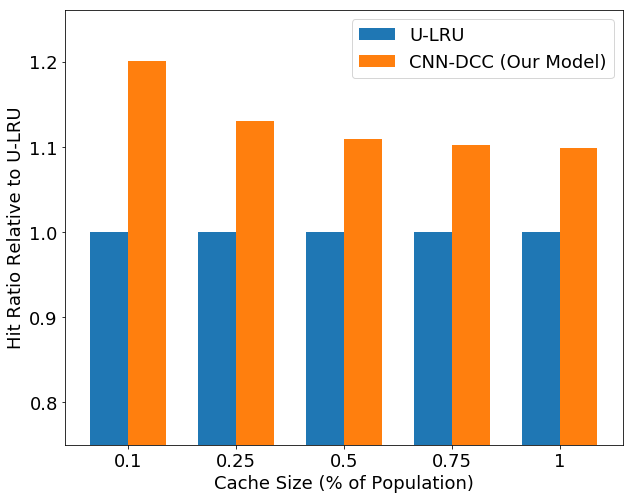

In [0]:
x = [0.1, 0.25, 0.5, 0.75, 1]
cnn_hit_r = [0.347,0.382,0.418,0.444,0.466]
lru_hit_r = [0.289,0.338,0.377,0.403,0.424]
cnn_relative =  [x/y for x, y in zip(cnn_hit_r, lru_hit_r)]
lru_relative = [1,1,1,1,1]
fig, ax = plt.subplots()
ind = np.arange(5)    # the x locations for the groups
width = 0.35         # the width of the bars
p1 = ax.bar(ind, lru_relative, width)
p2 = ax.bar(ind+width, cnn_relative, width)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('0.1', '0.25', '0.5', '0.75', '1'))
ax.legend((p1[0], p2[0]), ('U-LRU', 'CNN-DCC (Our Model)'))
ax.autoscale_view()
plt.gca().set_ylim(bottom=0.75)
plt.ylabel('Hit Ratio Relative to U-LRU')
plt.xlabel('Cache Size (% of Population)')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
plt.savefig('result.png')